# **Лабораторная работа №2. Математическое моделирование текстовых данных учебной аналитики**

# Описание работы

**Цель работы:** сформировать навыки работы с текстовыми данными и реализовать тематическое моделирование текстов.

**Задачи:**


1. Составить собственный корпус текстов, относящихся к тематике учебной аналитики.
2. Провести предобработку данных согласно требованиям исходных данных.
4. Реализовать тематическое моделирование текстов.
5. Объяснить полученные темы.
6. Выявить тексты с самой высокой степенью принадлежности к каждой теме (по 5 документов на каждую тему).
7. Визуализировать кластеры полученных тем.
2. Сделать выводы по работе, обосновать практическое применение полученных тематик.


## Возможные тематики корпуса текстов


*   Научные статьи о сфере образования
*   Отзывы студентов об образовательном процессе
*   Отзывы об образовательных организациях
*   Учебные тексты междисциплинарных направлений
*   Рабочие программы дисциплин
*   Учебная документация







## Обязательные требования


*   Корпус должен состять минимум из 100 документов общим объемом не менее 10 000 слов
*   Количество выделенных тем от 5 до 7



## Сбор данных
В качестве темы исследования выбраны отзывы студентов о российских вузах. Источник данных - сообщество "Типичный абитуриаент" в ВК: https://vk.com/tipichnuy_abiturient

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import numpy as np
import matplotlib.pyplot as plt

import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stopwords_list = stopwords.words("russian")

import pymorphy2
analyzer = pymorphy2.MorphAnalyzer()

import gensim.corpora as corpora
import gensim

import pyLDAvis
import pyLDAvis.gensim_models


vk_config = {"access_token": "59b0f44959b0f44959b0f4492a59c678e2559b059b0f449398390e6ad6653d75c656022",
             "version": "5.131"
            }

/Users/h3ic/.virtualenvs/tip/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


С помощью метода execute выполним несколько запросов и посмотрим на полученные данные

In [2]:
owner_id = -31709664 # domain 'tipichnuy_abiturient' - group.getById
count = 100
offset = 0

add_str = f'''arr.push(API.wall.get({{'owner_id':{owner_id},'count':{count},'offset':{offset}+a*{count}}}));'''
code = ('var a = 0;' +
        'var arr = [];' +
        'while (a != 10) {' +
        add_str +
        'a = a + 1;' +
        '};' +
        'return arr;'
        )

response = requests.post(
    url="https://api.vk.com/method/execute",
    data={
        'code': code,
        'access_token': vk_config['access_token'],
        'v': vk_config['version']
    }
)

data = response.json()

In [3]:
data['response'][0]['items'][0]

{'id': 404629,
 'from_id': -31709664,
 'owner_id': -31709664,
 'date': 1653480464,
 'marked_as_ads': 0,
 'post_type': 'post',
 'text': 'Наш telegram - https://t.me/tabiturient',
 'is_pinned': 1,
 'attachments': [{'type': 'link',
   'link': {'url': 'https://t.me/tabiturient',
    'title': 'Табитуриент.ру',
    'caption': 't.me',
    'description': 'Канал для поступающих в вузы',
    'photo': {'album_id': -28,
     'date': 1653480473,
     'id': 457399216,
     'owner_id': 2000022347,
     'sizes': [{'height': 130,
       'type': 'm',
       'width': 130,
       'url': 'https://sun9-1.userapi.com/impg/N9FbwpZ49wlyUrFIqcTUG3IEyqB0S9M68u68Jw/tZR8R33VpSw.jpg?size=130x130&quality=96&sign=f41c6db62531253f0dda7fcc0e0b284a&c_uniq_tag=so-up1UZEeKzppWeGVvVTMLqHLrI3DvajUzO9oNn6Tc&type=album'},
      {'height': 150,
       'type': 'p',
       'width': 150,
       'url': 'https://sun9-1.userapi.com/impg/N9FbwpZ49wlyUrFIqcTUG3IEyqB0S9M68u68Jw/tZR8R33VpSw.jpg?size=150x150&quality=96&sign=2f4a33dee137c

Отфильтруем рекламные посты, посмотрим на объем документов

In [4]:
json_response = data['response']

posts_data = []
for request_index in range(len(json_response)):
    json_items = json_response[request_index]['items']
    for item in range(len(json_items)): 
        try:
            text_field = json_items[item]['text']
            if (json_items[item]['marked_as_ads'] == 0) and (len(text_field) > 0) and (text_field.startswith('#ТАслив')):
                posts_data.append(text_field)
                
        except IndexError:
            continue

with open("corpus.json", "w") as f:
    json.dump(posts_data, f, ensure_ascii=False)

In [5]:
text_len = []

for text in posts_data:
    words = text.split()
    text_len.append(len(words))

print(text_len)

[1352, 264, 573, 475, 607, 215, 420, 602, 894, 380, 319, 764, 239, 1634, 436, 429, 313, 329, 348, 350, 628, 420, 842, 668, 228, 199, 224, 1166, 244, 690, 360, 355, 1606, 587, 319, 986, 185, 396, 506, 183, 250, 346, 262, 649, 547, 226, 1004, 248, 338, 490, 781, 278, 462, 793, 184, 356, 227, 198, 302, 471, 617, 204, 254, 414, 460, 482, 524, 514, 961, 2518, 276, 392, 415, 347, 215, 578, 177, 369, 204, 823, 749, 217, 441, 334, 295, 298, 621, 1672, 1234, 560, 248, 906, 341, 644, 1026, 924, 220, 1131, 746, 293, 445, 754, 1038, 1090, 319, 1702, 417, 1204, 221, 1641, 848, 381, 876, 275, 892, 254, 609, 391, 440, 882, 1106, 287, 1645, 301, 1197, 505, 340, 413, 318, 1822, 577, 395, 507, 290, 619, 1092, 651, 703, 1971, 243, 246, 209, 243, 631, 648, 344, 267, 359, 687, 468, 376, 388, 573, 558, 452, 1322, 204, 543, 1452, 402, 1078, 600, 780, 245, 265, 1070, 298, 1410, 632, 932, 305, 984, 2248, 461, 230, 509, 826, 167, 498, 330, 377, 408, 456, 677, 489, 277, 1059, 279, 1089, 785, 406, 465, 843, 225, 

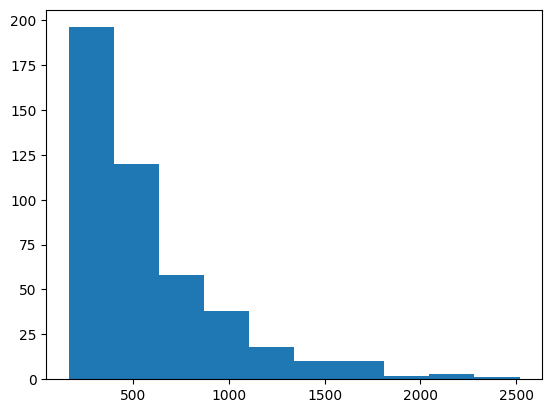

In [6]:
plt.hist(text_len);

In [7]:
posts_data[10]

'#ТАслив о ТюмГУ\nИнститут государства и права\n\nСтудент этого вуза: "Тестируют как на кроликах новую систему 2+2, где по сути 2 года вы занимаетесь полной ерундой, не относящейся к профессии, только с 3 курса будете хоть что-то делать и учить. Поступила с огромной мотивацией получать знания по желаемому направлению юрика. После пары лекций желание отпало учиться от слова совсем. Совершенно бесполезная система обучения, где ты должен сам по несколько часов в день сидеть и смотреть онлайн лекции, позже выполнять тестирования по ним. На наши возмущения, деканат сказал «ну что же вы, у вас ещё ещё магистратура, чтобы получить хорошую вышку.»а это на секунду 6 лет обучения, стоимостью 1300000, если не больше. Вы меня извините, я поступила сюда ради 4 лет учебы, а получается, что я переплачу за те два года, которые я провели изучая предметы, не относящиеся к профессии. Скитаешься между сайтами модеус, вместе, приложениями тимс, гет курс, one note, дабы сделать домашку. Дается выбор электив

In [8]:
print('Количество документов в корпусе', len(posts_data))
print('Количество слов в корпусе:', sum(text_len))
print('Медианное количество слов в документе:', np.median(text_len))

Количество документов в корпусе 456
Количество слов в корпусе: 261941
Медианное количество слов в документе: 450.5


In [9]:
with open("reviews_corpus.json", "w") as f:
    json.dump(posts_data, f, ensure_ascii=False)

## Очистка корпуса
Необходимо избавиться от: эмодзи, ссылок, стоп-слов, токенизировать слова и лемматизировать токены

In [10]:
with open('reviews_corpus.json', 'r') as f:
    corpus_json = json.load(f)

In [11]:
emoji_pattern = re.compile('['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U0001F1F2-\U0001F1F4'
        u'\U0001F1E6-\U0001F1FF'  
        u'\U0001F600-\U0001F64F'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        u'\U0001f926-\U0001f937'
        u'\U0001F1F2'
        u'\U0001F1F4'
        u'\U0001F620'
        u'\u200d'
        u'\u2640-\u2642'
        u'\U0001F919'  # added emojis
        u'\U000026E9'
        u'\U0001F913'
        u'\U0001F9D0'
        u'\U00002705'
        u'\U00002753'
        u'\U0001F926'
        u'\U0001F937'
        u'\U0001F918'
        u'\U0001F9ED'
        ']+', flags=re.UNICODE)

url_pattern = re.compile(r'https?://(?:www\.)?(?:[-a-zA-Z0-9@:%._\+~#=/?&]+)')

В ходе работы были рассмотрены варианты моделирования для всех частей речи и для каждой в отдельности (NOUN, VERB, ADJS/F).<br/>
Результат, поддающийся интерпретации, с четким разделением тем, дает моделирование с использованием прилагательных и кратких прилагательных.<br/>
Поэтому на этапе очистки корпуса были оставлены только те токены, которые pymorphy отметил как прилагательные

In [12]:
re_tokenizer = RegexpTokenizer(r'[А-яA-z-ё]+')
common_words = [
'просто',
'отзыв',
'слив'

'студент',
'преподаватель',
'обучение',
'год',
'пара',
'курс',
'предмет',
'факультет',
'большой',
'хороший',
'учиться',
'человек',
'учёба'
]

common_verbs = ['хотеть', 'хотеться', 'учиться']
stopwords_list.extend(['из-за', 'аж', 'это', 'который', 'также', 'всё', 'свой', 'ещё', 'весь', 'ваш', 'очень', 'вуз', 'таслить', 'каждый', 'самый', 'вообще', 'мочь', 'являться', 'просто', 'либо', 'хотя', 'присылать', 'сюда'])
stopwords_list.extend(common_words)
stopwords_list.extend(common_verbs)

def preprocess(doc: str):
    # regex
    regexed_doc = re.sub('\n', ' ', doc)
    regexed_doc = emoji_pattern.sub('', regexed_doc)
    regexed_doc = url_pattern.sub('', regexed_doc)

    # tokenization
    tokens = re_tokenizer.tokenize(regexed_doc)
    tokens = [token.lower() for token in tokens if len(token) > 1 and token.isalpha() and not re.match(r'[А-Я]{2,}', token)]
    # lemmatization
    norm_doc = [analyzer.parse(word)[0].normal_form for word in tokens if analyzer.parse(word)[0].tag.POS in ['ADJF', 'ADJS']]
    # stopwords
    tokenized_doc = [word for word in norm_doc if word not in stopwords_list]

    return tokenized_doc

In [13]:
corpus = []
for i, doc in enumerate(corpus_json):
    corpus.append(preprocess(doc))

with open('clean_corpus.json', 'w') as f:
    json.dump(corpus, f, ensure_ascii=False)

In [14]:
doc_lens = []
for doc in corpus:
	doc_lens.append(len(doc))

print(len(corpus))
print(np.sum(doc_lens))
print(np.median(doc_lens))

456
19983
34.5


## Генерация n-грамм

In [15]:
with open('clean_corpus.json', 'r') as f:
    corpus = json.load(f)

In [16]:
def make_trigrams(texts):
  bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram = gensim.models.Phrases(bigram[texts], threshold=100)  
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_trigrams = make_trigrams(corpus)

## Тематическое моделирование

In [17]:
# Создаем словарь
id2word = corpora.Dictionary(data_trigrams)
# Определяем частоту документа в корпусе
bow_corpus = [id2word.doc2bow(text) for text in data_trigrams]

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, 
                                            id2word=id2word,
                                            num_topics=5,
                                            minimum_probability=0.1,
                                            passes = 20,
                                            iterations = 1000,
                                            random_state=1)

In [19]:
# Вывод полученных тем
lda_model.print_topics(lda_model.num_topics)

[(0,
  '0.020*"первый" + 0.015*"нормальный" + 0.011*"новый" + 0.011*"английский" + 0.011*"некоторый" + 0.010*"больший" + 0.010*"готовый" + 0.010*"остальной" + 0.010*"нужный" + 0.010*"общий"'),
 (1,
  '0.038*"первый" + 0.018*"второй" + 0.015*"учебный" + 0.015*"некоторый" + 0.014*"английский" + 0.013*"наш" + 0.012*"больший" + 0.011*"общий" + 0.011*"разный" + 0.011*"должный"'),
 (2,
  '0.024*"первый" + 0.015*"общий" + 0.013*"нужный" + 0.012*"учебный" + 0.011*"любой" + 0.011*"должный" + 0.011*"новый" + 0.010*"второй" + 0.010*"остальной" + 0.010*"научный"'),
 (3,
  '0.014*"первый" + 0.013*"сложный" + 0.012*"остальной" + 0.011*"общий" + 0.010*"любой" + 0.010*"никакой" + 0.009*"горный" + 0.009*"учебный" + 0.009*"ядерный" + 0.006*"полный"'),
 (4,
  '0.019*"юридический" + 0.014*"учебный" + 0.011*"высокий" + 0.010*"горный" + 0.009*"наш" + 0.009*"некоторый" + 0.008*"практический" + 0.008*"студенческий" + 0.007*"должный" + 0.007*"интересный"')]

## Визуализация

In [20]:
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, id2word)
pyLDAvis.display(vis)

/Users/h3ic/.virtualenvs/tip/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/h3ic/.virtualenvs/tip/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/h3ic/.virtualenvs/tip/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/h3ic/.virtualenvs/tip/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Py

1: Основной кластер, включающий 2 и 3 - основная тема, включающая основные характеристики и отношение автора: первый, второй (вероятно, номер курса), общий, разный, должный, интересный, плохой. Eсть как и положительные, так и отрицательные эпитеты
<br/>2: Содержит много слов, описывающих процесс: лабораторный, научный, студенческий, учебный, преподавательский, дистанционный. Также превалируют положительные эпитеты: нужный, новый, высокий, интересный
<br/>3: Содержит такие слова как: русский, английский, немецкий. Вероятно, эта подтема могла выделиться отчасти из отзывов студентов иняза
<br/>
<br/>4 и 5 темы меньше, в них объединились некоторые сферы и характеристики
<br/>
<br/>4: Здесь: юридический, медицинский, горный, практический; классный, приятный, адекватный
<br/>5: Здесь: ядерный, гостиничный, инженерный, также никакой, дорогой, ненужный


С большим количеством данных может выделиться больше специфичных кластеров, подобных 3, 4 и 5 - через них можно проследить отношение студентов указанных направлений к вузам, в которых реализуются указанные программы. Для такого моделирования помимо прилагательных можно оставить в корпусе и некоторые существительные, например, названия дисциплин и специфические для сфер слова.

## Выделим типичные для кластеров документы

In [21]:
from itertools import chain

lda_corpus = lda_model[bow_corpus]

scores = list(chain(*[[score for _,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))

threshold = sum(scores)/len(scores)
print(threshold)


0.8235145946601768


In [32]:
def nth_cluster(n):
	# i = (topic_n, score)
	# docs = [(score, doc)]
	docs = [(i[0][1],j) for i,j in zip(lda_corpus,posts_data) if (i[0][0] == n - 1) and i[0][1] > threshold]
	docs = sorted(docs, key=lambda x: x[0])[:5]
	str = ''
	for i, doc in enumerate(docs):
		str += f'\n===== {i + 1} =====\n' + doc[1]
	return str

In [31]:
for i in range(1, 6):
	with open(f'{i}.txt', 'w') as f:
		f.write(nth_cluster(i))

## Вывод
В ходе проделанной работы были собраны данные студентов об учебных заведениях, составлен корпус, проведено тематическое моделирование, выделены типичные для каждой темы тексты